

 Обучение нейронной сети для для классификации кошек и собак

*Не забудьте добавить в Runtime GPU для ускорения вычислений*.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [34]:
# Загрузка датасета 
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [35]:
! ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [36]:
# создание директорий для тренировочных и валидационных данных
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [37]:
# проверка целостности данных
num_cats_tr = len(list(train_cats_dir.glob("*")))
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [38]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [39]:
# размер батчей
BATCH_SIZE = 100
IMG_SHAPE  = 150 

In [40]:
# создание генераторов загрузк батчей для тренировочных и валидационных данных и нормализация значений пикселей в изображении
train_image_generator      = ImageDataGenerator(rescale=1./255)  
validation_image_generator = ImageDataGenerator(rescale=1./255)  

In [41]:
# указываем откуда считывать нормализованные данные(валидационные данные не перемешиваем)
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [50]:
# проверка полученных классов
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

In [1]:
# как только мы вополним эту команду, мы считаем 100 картинок с диска и преобразуем их к нужному формату
sample_training_images, sample_labels = next(train_data_gen) 
sample_training_images.shape, sample_labels.shape # 4x мерный тензор и вектор из меток класса

NameError: ignored

In [43]:
_val_images, _val_labels = next(val_data_gen)
next(val_data_gen)[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [44]:
# функция просмотра изображений и меток класса 
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

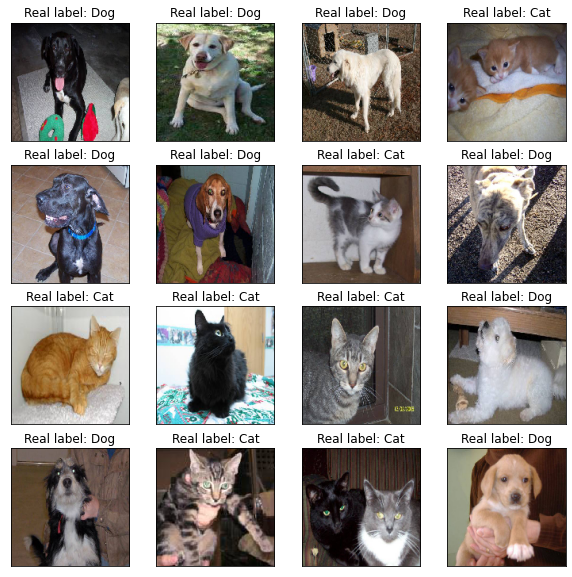

In [45]:
show_catsdogs(sample_training_images, sample_labels)

In [115]:
# Определение модели сверточной нейронной сети
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', 
                                 activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='valid', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='valid', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))



In [114]:
train_data_gen.image_shape

(150, 150, 3)

In [116]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [117]:
# проверка параметров 
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 15, 15, 128)     

In [119]:
# для более удобного и наглядного отображения обучения мы воспользуемся библиотекой,
# которая реализует коллбек, отображающий кривые обучения в режиме реального времени.
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

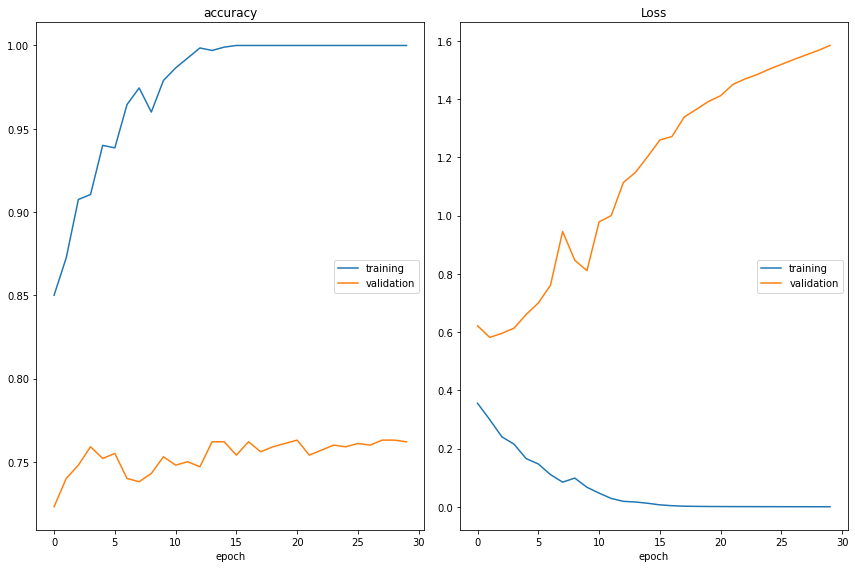

accuracy
	training         	 (min:    0.850, max:    1.000, cur:    1.000)
	validation       	 (min:    0.723, max:    0.763, cur:    0.762)
Loss
	training         	 (min:    0.000, max:    0.356, cur:    0.000)
	validation       	 (min:    0.582, max:    1.584, cur:    1.584)


In [120]:
# указанными параметрами спустя 30 эпох вы увидите точность около 75%. 
EPOCHS = 30
history = model.fit(
    train_data_gen,
    epochs=EPOCHS, 
    validation_data=val_data_gen, 
    callbacks=[PlotLossesCallback()]) # мы добавили коллбек для отрисовки прогресса #callbacks=[PlotLossesCallback()]

Теперь посмотрим на предсказания нашей сети:

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


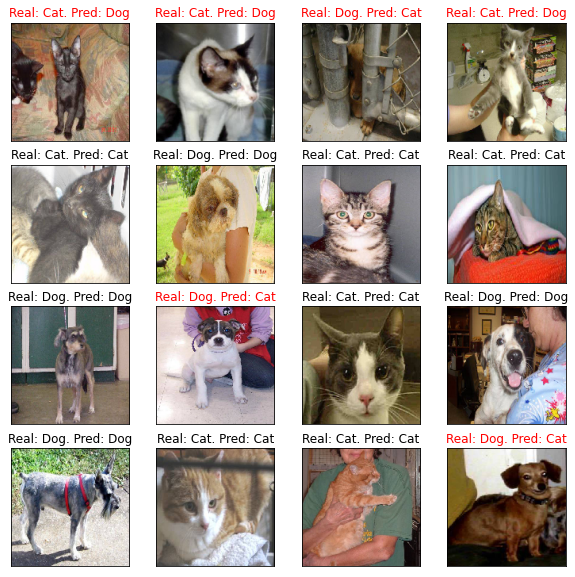

In [121]:
# предсказания сети:
shuffle_val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')
sample_validation_images, sample_validation_labels = next(shuffle_val_data_gen)
predicted = model.predict_classes(sample_validation_images).flatten()
show_catsdogs(sample_validation_images, sample_validation_labels, predicted)